In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf, adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

## Stationary or non-statioanry

[Otexts books](https://otexts.com/fpp3/stationarity.html)

[statsmodels documentation](https://www.statsmodels.org/stable/tsa.html)

<br>

`statsmodels.tsa` contains model classes and functions that are useful for time series analysis.

<br>

### stationary

is a property that do not depend on the time at which the series is observed.Thus, time series with trends, or with seasonality, are not stationary.

> time series with cyclic behaviour is stationary, since cycles are not of a fixed length

> In statistics a stationary series is one whose statistical properties such as mean, variance, covariance, and standard deviation do not vary with time,

- roughly horizontal
- constant variance
- not predictable patterns in the long-term

<br>

So, if we have non-stationary data:

- transformation helps to stabilize the **variance**
- for ARIMA we also need to stabilize the **mean**

<br>

**Types of Stationary Series**

- Strict Stationary – Satisfies the mathematical definition of a stationary process. Mean, variance & covariance are not a function of time.
- Seasonal Stationary – Series exhibiting seasonality.
- Trend Stationary – Series exhibiting trend.

<br>

**Identify non-stationary series**

- plot time data
- ACF (autocorrelation) of stationary data drops to zero quickly
- for non-stationary data, $r_1$ value is often large and positive


### Lag vs Difference

In lag we shift the entire time series forward by one or more time periods.
- Purpose: This is essential for analyzing relationships between a value and its own past (autocorrelation) and for building forecasting models (like ARIMA).
- pandas: `df.shift(lag) # lag = 1, 2, 3, ...`

A difference is the change between consecutive observations ($y_t - y_{t-1}$)
- Purpose: To remove trend and seasonality, making a non-stationary time series stationary. Differencing helps **stabilize the mean** of the series.

> Second difference: $(y_t - y_{t-1}) - (y_{t-1} - y_{t-2}) = y_t - 2y_{t-1} + y_{t-2}$
- pandas: `df.diff() # this is difference with lag_1`, `ts.diff().diff().values # second diff`

> If there is seasonal pattern we can use `df.diff(12)` for 12 as season.


Signs you need seasonal differencing:

- Significant spikes at seasonal lags (lag 12, 24, 36 for monthly data)
- Spikes that don't decay quickly at seasonal intervals
- The pattern repeats at fixed intervals

```
Start
  ↓
Plot your data + ACF plot
  ↓
Are there clear seasonal patterns? → NO → Use regular differencing (diff(1))
  ↓ YES
Identify seasonal period (m)
  ↓
Apply seasonal differencing: df.diff(m)
  ↓
Check if seasonal pattern is removed
  ↓
If needed, combine with regular differencing
```


### Unit root tests

[Reference](https://www.analyticsvidhya.com/blog/2021/06/statistical-tests-to-check-stationarity-in-time-series-part-1/) + some other resources

These methods statistically determine if a time series is non-stationary and needs differencing. The most common tests:

- ADF (Augmented Dickey-Fuller)
- KPSS (Kwiatkowski-Phillips-Schmidt-Shin)
- PP (Phillips-Perron)

#### **ADF**
> Null Hypothesis ($H_0$): The time series has a unit root (non-stationary)

```py
from statsmodels.tsa.stattools import adfuller

# The second item is P_value: result[1]
    # if P_value < 0.05 --> reject H₀ --> stationary
result = adfuller(timeseries, autolag='AIC')
```
> There are 5 items in output and the last one is dictionary of critical values

keys | values
----|------
0 - Test Statistic                | 2.837781
1 - p-value                       | 0.053076
2 - Lags Used                    | 8.000000
3 - Number of Observations Used | 300.000000
4 - Critical Value (1%)          | -3.452337
4 - Critical Value (5%)          | -2.871223
4 - Critical Value (10%)         | -2.571929

> If test statistic > critical value → Fail to reject H₀ (non-stationary)<br>
p-value > 0.05 → Fail to reject H₀

<br>

### **KPSS Test**
> Null Hypothesis ($H_0$): The time series is stationary

```py
from statsmodels.tsa.stattools import kpss

# The second item is P_value: result[1]
    # if P_value < 0.05 --> reject H₀ --> non-stationary
result = kpss(timeseries, regression='c', nlags="auto")
```
> > There are 4 items in output and the last one is dictionary of critical values

<br>

ADF Test | KPSS Test | Conclusion | Action
---------|-----------|------------|-------
p < 0.05 | p > 0.05 | Stationary | No differencing needed
p > 0.05 | p < 0.05 | Non-stationary | Apply differencing
p < 0.05 | p < 0.05 | Trend stationary | May need detrending
p > 0.05 | p > 0.05 | Difference stationary | Apply differencing

<br>

- test_statistic < critical_values 1%': TRONGLY STATIONARY (p < 0.01)
- test_statistic < critical_values 5%': STATIONARY (p < 0.05)
- test_statistic < critical_values 10%: WEAKLY STATIONARY (p < 0.10)

---
---

<br>

> Regular ADF tests check for unit roots at frequency 0 (overall trend), but they don't specifically test for seasonal patterns that repeat at fixed intervals.

> OCSB or Canova-Hansen tests for seasonal unit roots

In [2]:
!mkdir ~/.kaggle
!cp ./kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c store-sales-time-series-forecasting
!unzip /content/store-sales-time-series-forecasting.zip

  0% 0.00/21.4M [00:00<?, ?B/s]
100% 21.4M/21.4M [00:00<00:00, 416MB/s]
Archive:  /content/store-sales-time-series-forecasting.zip
  inflating: holidays_events.csv     
  inflating: oil.csv                 
  inflating: sample_submission.csv   
  inflating: stores.csv              
  inflating: test.csv                
  inflating: train.csv               
  inflating: transactions.csv        


In [3]:
df = pd.read_csv('/content/train.csv', parse_dates = ['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [4]:
daily_stats = df.groupby('date').agg(
    {
        'sales': 'sum',
        'store_nbr': 'count',
        'onpromotion': 'sum'
    }
)

daily_stats.columns = ['total_sales', 'total_stores', 'total_promotions']

daily_stats.tail()

,total_sales,total_stores,total_promotions
date,,,
2017-08-11,826373.722022,1782,14179
2017-08-12,792630.535079,1782,8312
2017-08-13,865639.677471,1782,9283
2017-08-14,760922.406081,1782,8043
2017-08-15,762661.935939,1782,10605


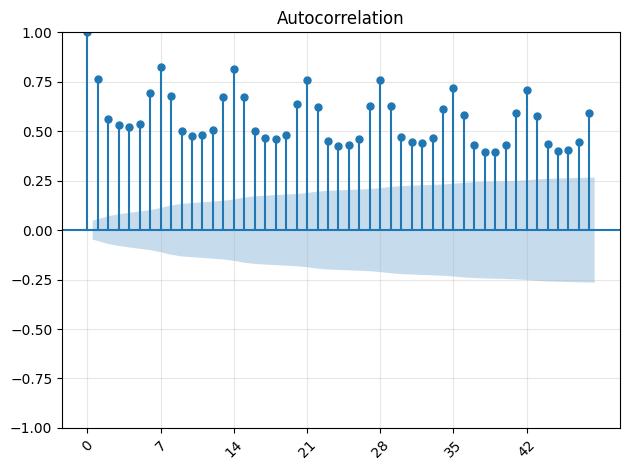

In [46]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(daily_stats['total_sales'], lags=48)
plt.xticks(range(0, 49, 7), range(0, 49, 7), rotation = 45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [52]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(daily_stats['total_sales'], autolag='AIC')

dfoutput = pd.Series(result[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key, value in result[4].items():
    dfoutput[f'Critical Value {key}'] = value

print (dfoutput)

Test Statistic                   -2.616196
p-value                           0.089696
#Lags Used                       22.000000
Number of Observations Used    1661.000000
Critical Value 1%                -3.434293
Critical Value 5%                -2.863282
Critical Value 10%               -2.567697
dtype: float64


In [53]:
from statsmodels.tsa.stattools import kpss

result = kpss(daily_stats['total_sales'], regression='c', nlags="auto")
kpss_output = pd.Series(result[0:3], index=['Test Statistic','p-value','#Lags Used'])
for key, value in result[3].items():
    kpss_output[f'Critical Value {key}'] = value

print (kpss_output)

Test Statistic          5.737661
p-value                 0.010000
#Lags Used             24.000000
Critical Value 10%      0.347000
Critical Value 5%       0.463000
Critical Value 2.5%     0.574000
Critical Value 1%       0.739000
dtype: float64


/tmp/ipython-input-2114035822.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(daily_stats['total_sales'], regression='c', nlags="auto")


### Seasonal Decomposition

It decomposes a time series into three components:
- Trend: Long-term direction (increasing/decreasing/stable)
- Seasonal: Regular, repeating patterns
- Residual: Random noise left after removing trend and seasonality

> Additive Model: Observed = Trend + Seasonal + Residual <b>
when: Seasonal variations are constant throughout the series.

> Multiplicative Model: Observed = Trend × Seasonal × Residual <br>
when: Seasonal variations grow with the trend.

<br>

#### **Check if seasonal variation scales with level**

```py
rolling_mean = series.rolling(window=7).mean()
rolling_std = series.rolling(window=7).std()
    
# If variance increases with level → multiplicative
if (rolling_std / rolling_mean).mean() > 0.1:
    model = 'multiplicative'
else:
    model = 'additive'
```

0.2139166554623411


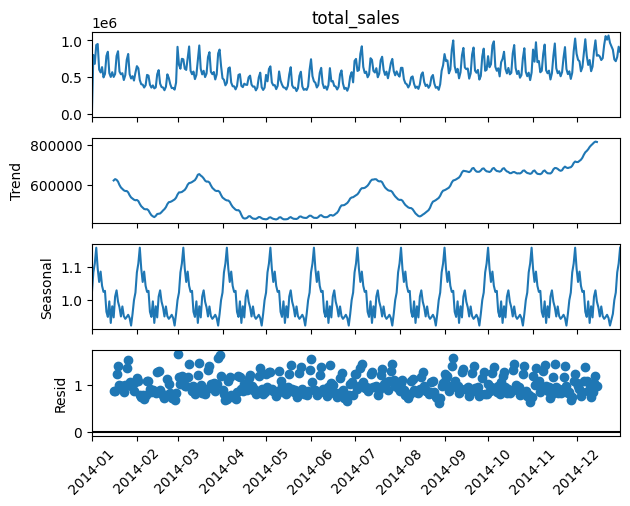

In [305]:
from statsmodels.tsa.seasonal import seasonal_decompose

rolling_mean = daily_stats['total_sales'].rolling(window=7).mean()
rolling_std = daily_stats['total_sales'].rolling(window=7).std()

print((rolling_std / rolling_mean).mean())

result = seasonal_decompose(daily_stats['total_sales'][daily_stats.index.year == 2014], model = "multiplicative", period = 30)

trend_component = result.trend
seasonal_component = result.seasonal
residual_component = result.resid


# One year
result.plot()
plt.xticks(rotation = 45)
plt.show()

## Autoregressive and moving average model

---
---
In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

$$
y_t = c + \phi_1 y_{t−1} + \phi_2 y_{2−1} + ⋯ + \phi_p y_{t−p} + \epsilon_t
$$

> where $\epsilon_t$ is white noise. This is like a multiple regression but with lagged values of $y_t$ as predictors. We refer to this as an AR($p$) model, an autoregressive model of order $p$.

> The variance of the error term $\epsilon_t$ will only change the scale of the series, not the patterns.

<br>

- *The Auto-Regressive* (AR) model assumes that the current value $y_t$ is **dependent on previous values** $y_{t-1}, y_{t-2}, …$
    - Because of this assumption, we can build a linear regression model.
---
---

<br>

Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model,

$$
y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + ...+ + \theta_q \epsilon_{t-q}
$$

> where $\epsilon_t$ is white noise. We refer to this as an MA($q$) model, a moving average model of order $q$. Of course, we do not observe the values of $\epsilon_t$, so it is not really a regression in the usual sense.

<br>

- *The Moving Average* (MA) model assumes that the current value $y_t$ is **dependent on the error terms** including the current error $𝜖_t, 𝜖_{t-1},…$.
    - Because error terms are random, there’s no linear relationship between the current value and the error terms.
<br>

---
---

The **ACF** and **PACF** are used to figure out the order of AR, MA, and ARMA models.
- you can see a blue area in the ACF and PACF plots. This blue area depicts the 95% confidence interval and is an indicator of the significance threshold. That means, anything within the blue area is statistically close to zero and anything outside the blue area is statistically non-zero.
    - so if the are to many plot out of the blue area data are random


 none 	| AR(p) | MA(q) | ARMA(p, q)
--------|-------|-------|-----------
ACF | Tails off (Geometric decay)(damped exponentian or sin)| Significant at lag q / Cuts off after lag q | Tails off (Geometric decay)(damped exponentian or sin) after lag mac(0, q - p)
PACF | Significant at each lag  p / Cuts off after lag p | Tails off (Geometric decay)(damped exponentian or sin) | Tails off (Geometric decay)(damped exponentian or sin) after lag mac(0, p - q)

<br>

[ACF and PACF plots](https://towardsdatascience.com/interpreting-acf-and-pacf-plots-for-time-series-forecasting-af0d6db4061c/)

[Kaggle](https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf/notebook)

[Video](https://www.youtube.com/watch?v=ZE_WGBe0_VU)

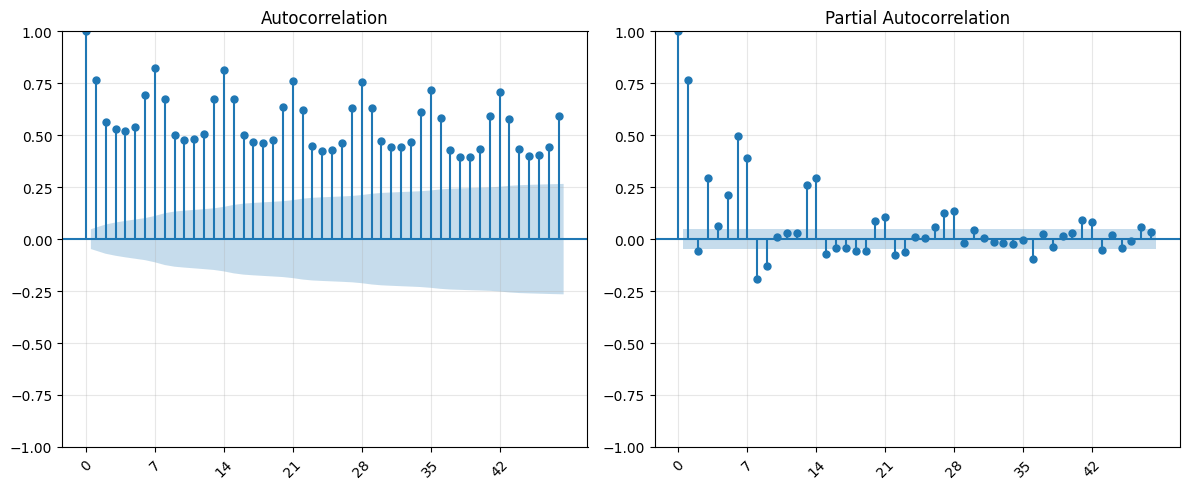

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plot_acf(daily_stats['total_sales'], lags=48, ax = plt.gca()) # Cutt of for MA model
plt.xticks(range(0, 49, 7), range(0, 49, 7), rotation = 45)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plot_pacf(daily_stats['total_sales'], lags=48, ax = plt.gca(),  method = "ols") # Cutt of for AR model
plt.xticks(range(0, 49, 7), range(0, 49, 7), rotation = 45)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Remove trends or seasonal patterns using Differencing

> Purpose: Fix non-stationarity in mean (trends/seasonality)

> if adf_p_value > 0.05 so data is non-stationary<br>
if kps_p_value < 0.05 so data is non-stationary

```py
from statsmodels.tsa.stattools import kpss, adfuller

# calculate one of them
adf = adfuller(current_data)[1]
kps = kpss(current_data)[1]

if adf > 0.05:
        # Try regular differencing
        diff_1 = current_data.diff(1).dropna()

# do it again to check if it's became stationary or not
df_diff1 = adfuller(diff_1)[1]
```

```py
original = daily_stats['total_sales']

# First difference - removes linear trend
first_diff = original.diff(1)
# If first difference isn't enough (curved trend)
second_diff = original.diff(1).diff(1)  # Or original.diff().diff()

# Remove weekly patterns (7-day seasonality)
seasonal_diff_7 = original.diff(7)

# Remove both trend AND seasonality
combined_diff = original.diff(1).diff(7)  # Or original.diff(7).diff(1)
```

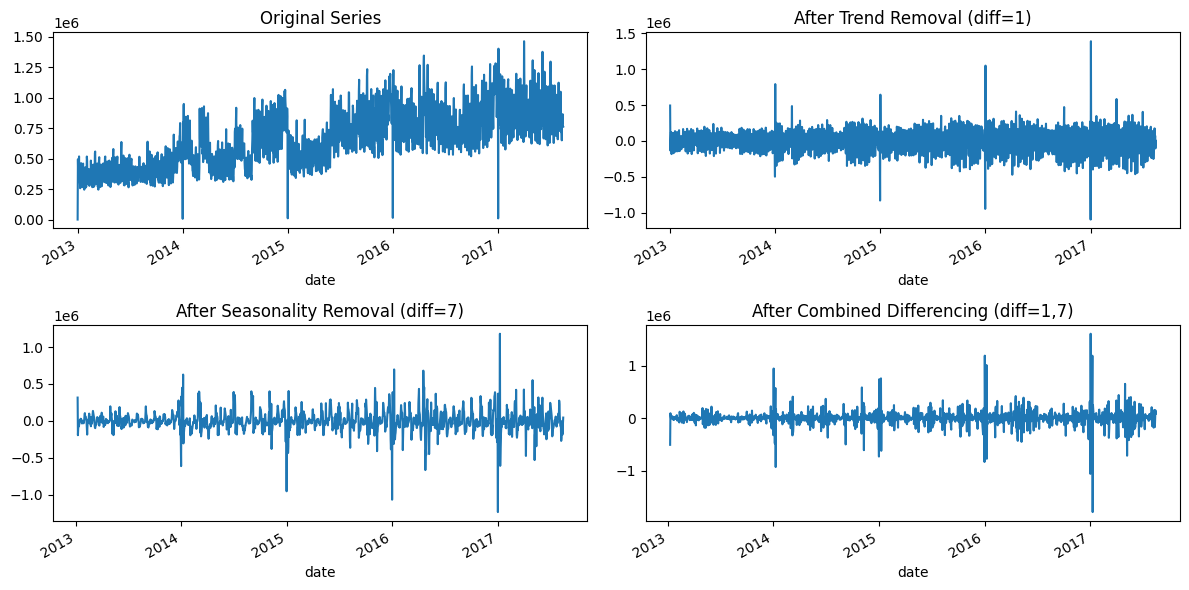

In [89]:
original = daily_stats['total_sales']
# Remove both trend AND seasonality
combined_diff = original.diff(1).diff(7)  # Or original.diff(7).diff(1)

# Plot all steps
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

original.plot(ax=axes[0, 0], title='Original Series')
original.diff(1).plot(ax=axes[0, 1], title = 'After Trend Removal (diff=1)')
original.diff(7).plot(ax=axes[1, 0], title = 'After Seasonality Removal (diff=7)')
combined_diff.plot(ax=axes[1, 1], title = 'After Combined Differencing (diff=1,7)')

plt.tight_layout()
plt.show()

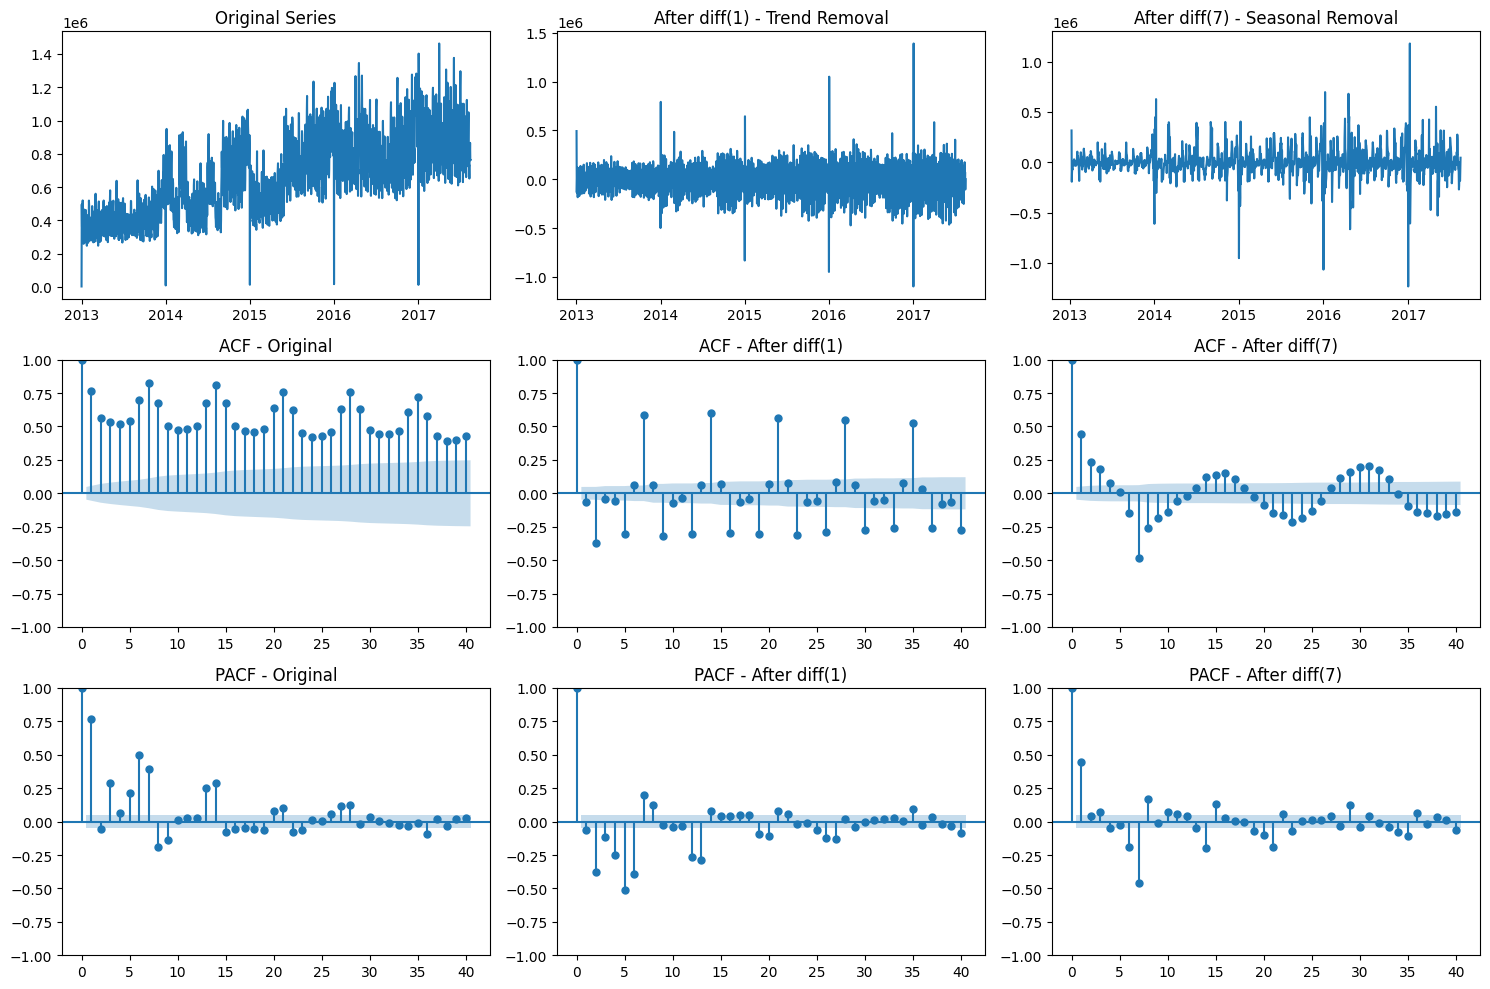

In [32]:
def visual_differencing(series, period = 7):
    """
    Visual method to choose differencing type
    """
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))

    # Original series and ACF
    axes[0,0].plot(series)
    axes[0,0].set_title('Original Series')
    plot_acf(series, ax=axes[1,0], lags=40)
    axes[1,0].set_title('ACF - Original')
    plot_pacf(series, ax=axes[2,0], lags=40)
    axes[2,0].set_title('PACF - Original')

    # After regular differencing
    diff_1 = series.diff(1).dropna()
    axes[0,1].plot(diff_1)
    axes[0,1].set_title('After diff(1) - Trend Removal')
    plot_acf(diff_1, ax=axes[1,1], lags=40)
    axes[1,1].set_title('ACF - After diff(1)')
    plot_pacf(diff_1, ax=axes[2,1], lags=40)
    axes[2,1].set_title('PACF - After diff(1)')

    # After seasonal differencing
    diff_seasonal = series.diff(period).dropna()
    axes[0,2].plot(diff_seasonal)
    axes[0,2].set_title(f'After diff({period}) - Seasonal Removal')
    plot_acf(diff_seasonal, ax=axes[1,2], lags=40)
    axes[1,2].set_title(f'ACF - After diff({period})')
    plot_pacf(diff_seasonal, ax=axes[2,2], lags=40)
    axes[2,2].set_title(f'PACF - After diff({period})')

    plt.tight_layout()
    plt.show()

visual_differencing(daily_stats['total_sales'])

Panel | Description | Interpretation
------| ------------|--------------
Original Series | Raw series before differencing. | Strong upward trend and seasonality — clear signs of non-stationarity (variance & mean change over time).
After diff(1) | First differencing → removes trend. | Trend largely removed — mean stabilized, but still has repeating seasonal spikes (e.g. weekly pattern). Need another seasonal differencing.
After diff(7) | Seasonal differencing (lag=7, assuming daily data with weekly cycle). | Looks more stationary: mean around zero, constant variance, no visible periodic structure.

<br>

Panel | Description | Interpretation
------| ------------|--------------
ACF – Original | Long positive lags slowly decaying. | Typical of non-stationary series — confirms need for differencing (trend and seasonality present).
ACF – After diff(1) | Still periodic spikes every 7 lags. | Indicates weekly seasonality remains, so a seasonal difference is necessary.
ACF – After diff(7) | Decay is short, alternating positive-negative correlations. | Suggests stationarity achieved. Shows pattern typical of AR and MA mix (e.g., AR(1) or MA(1) behavior).



### Transformation

> Purpose: Fix non-constant variance (heteroscedasticity)

we need to segment data into different parts, then calculate variance of each part:

$$
\text{variance ratio} = \frac{max(\sigma_1, \sigma_2, ...)}{min(\sigma_1, \sigma_2, ...)}
$$

if $\textit{variance ratio} > 2.0$ then transform data

<br>

log transformation: `transformed = np.log(df)`
- inverse: `np.exp(df)`

squar transformation: `transformed = np.sqrt(df)`
- inverse: `np.square(df)`

box-cox: `transformed, lambda_val = stats.boxcox(series_clean)`
- inverse: `lambda x: stats.boxcox(x, lambda_val)`

```py
# Here for demonstration purposes I just use whole dataset var
variance_ratio = np.std(series_clean) / np.mean(series_clean)
min_max_ratio = series_clean.min() / series_clean.max()

if variance_ratio > 2.0
    # Apply Box-Cox to find optimal lambda
    boxcox_data, lambda_opt = stats.boxcox(series_clean)
```
boxcox lambda:
- 1: "No transformation needed",
- 0.5: "Square root transformation",
- 0: "Log transformation",
- -1: "Reciprocal transformation"



In [ ]:
from scipy import stats

# Apply Box-Cox transformation
transformed, fitted_lambda = stats.boxcox(daily_stats['total_sales'].dropna())
fitted_lambda

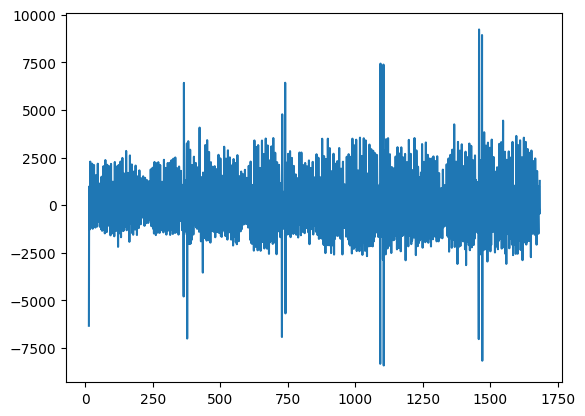

In [9]:
# most of the time we need to apply transformation and seasonal remove
#   since data is: growing trend + seasonal patterns + increasing variance
# → Apply Box-Cox THEN differencing

# Temperature Data (Usually needs DIFFERENCING only)

sales_transformed, lambda_val = stats.boxcox(daily_stats['total_sales'].dropna())
sales_ready = pd.Series(sales_transformed).diff(1).diff(12).dropna()  # Monthly data
sales_ready.plot()
plt.show()

##Model Overview
Model | Components | Use Case | Parameters
------|------------|----------|-----------
AR (AutoRegressive) | Uses past values | Short-term dependencies | p
MA (Moving Average) | Uses past errors | Shock effects | q
ARMA | AR + MA | Stationary series | p, q
ARIMA | AR + I +  MA | Non-stationary series | p, d, q
SARIMA | Seasonal ARIMA | Seasonal patterns | p, d, q, P, D, Q, s

<br>

Symbol | Meaning | Description
-------|---------|------------
p | AR order | number of autoregressive (lag) terms
d | differencing order | how many times the data is differenced to remove trend
q | MA order | moving average window size, also known as the order of the moving average.
P | seasonal AR order | AR order at seasonal lag (e.g. 12 for monthly, 7 for weekly)
D | seasonal differencing | number of seasonal differences
Q | seasonal MA order | MA order at seasonal lag
m | seasonal period | number of steps per season (12 for months, 7 for weekly)


<br>

### **Differencing: d and D**

we need to check P_value using `adfuller` or `kpss` model:<br>
> If adf_p_value < 0.05 → stationary → d = 0

for each `df.diff(1)`, `df.diff().diff()`, `df.diff(7)` we need to check.<br>
we can apply for loop for one level `diff(d)` for diferent `d`

If the series shows repeating patterns every `m` steps (weekly, yearly):
- Try `diff(m)` (diff(7) or diff(12)).
- If ACF shows strong spike at lag m → seasonal → use D = 1.
- Usually D ≤ 1.

<br>

### **Determine p and q using ACF/PACF**

I mention this above in a table: <br>
ACF decays gradually, PACF cuts off after lag p → AR(p)
- PACF spike at lag 1, ACF tail → AR(1)

PACF decays gradually, ACF cuts off after lag q → MA(q)
- ACF spike at lag 1, PACF tail → MA(1)

Both decay gradually → ARMA(p, q)
- Both tail → ARMA(1,1)

<br>

### **Seasonal components (P, Q)**

Look at ACF/PACF at multiples of the seasonal period (e.g., 7, 14, 21 for weekly).

ACF spike at lag m, 2m, … , PACF tail → Seasonal MA(Q) <br>
PACF spike at lag m, 2m, … , ACF tail → Seasonal AR(P)


### **Automated Parameter Selection**

```py
from pmdarima.arima import auto_arima
# Lower case represent non-seasonal
# Upper case represent seasonal

arima_model = auto_arima(
    df_ewm["Close"],
    start_p=0, d=0, start_q=0,
    max_p=10, max_q=10, max_d=10,
    start_P=0, D=0, start_Q=0,
    max_P=10, max_Q=10, max_D=10,
    seasonal=True,
    trace=True,
    error_action='ignore',
    suppress_warnings= True,
    stepwise=True,
    n_fits=10
)

# arima_model = auto_arima(
#     df_log["Close"],
#     trace=True,
#     suppress_warnings= True,
# )
```

In [41]:
# It's not a reliable funciton
def interpret_acf_pacf(series, max_lags = 7):
    """
    Interpret ACF and PACF patterns
    """
    from statsmodels.tsa.stattools import acf, pacf

    # Calculate ACF and PACF
    acf_values = acf(series, nlags=max_lags)
    pacf_values = pacf(series, nlags=max_lags)

    # Find significant lags
    # Calculates the 95% confidence interval for autocorrelation values.
    # 1.96 = Z-score for 95% confidence (2.5% in each tail)
    # Formula: ±1.96/√n
    conf_int = 1.96 / np.sqrt(len(series))

    # find idx of each lag that greater than threshhold and +1 to match lag number
    sig_acf = np.where(np.abs(acf_values[1:]) > conf_int)[0] + 1  # +1 because we skip lag 0
    sig_pacf = np.where(np.abs(pacf_values[1:]) > conf_int)[0] + 1


    # Common patterns
    if len(sig_acf) == 0 and len(sig_pacf) == 0:
        print("White noise - no AR or MA needed")
        return 0, 0
    elif len(sig_pacf) > 0 and sig_pacf[0] == 1 and len(sig_acf) > 1:
        print("AR signature: PACF cuts off, ACF tails off")
        p = sig_pacf[0]  # First significant PACF lag
        q = 0
    elif len(sig_acf) > 0 and sig_acf[0] == 1 and len(sig_pacf) > 1:
        print("MA signature: ACF cuts off, PACF tails off")
        p = 0
        q = sig_acf[0]  # First significant ACF lag
    else:
        print("Mixed ARMA pattern")
        p = min(sig_pacf[:2]) if len(sig_pacf) > 0 else 1
        q = min(sig_acf[:2]) if len(sig_acf) > 0 else 1

    return p, q

# Find p and q for your differenced data
stationary_data = daily_stats['total_sales'].diff(1).dropna()
p, q = interpret_acf_pacf(daily_stats['total_sales'], max_lags = 7)

AR signature: PACF cuts off, ACF tails off


### model selection criteria

#### **AIC (Akaike Information Criterion):**

**Lower AIC is better**

```py
fitted = model.fit()
fitted.fic
```

- Measures: The relative quality of a statistical model
- Goal: Find the model that best explains the data with the fewest parameters
- Philosophy: "Trade-off between goodness-of-fit and complexity"

$$
AIC = 2k - 2\ln(L)
$$

> k = number of parameters in the model.<br>
L = maximum value of the likelihood function

<br>

#### **BIC (Bayesian Information Criterion)**

```py
fitted = model.fit()
fitted.bic
```

- Goal: Similar to AIC but with stronger penalty for complexity
- Better for: Larger datasets, when you want to avoid overfitting

$$
BIC = k·ln(n) - 2\ln(L)
$$

>k = number of parameters <br>
n = number of observations <br>
L = maximum likelihood


Differences:

- AIC is more accurate
- BIC penalizes complexity more heavily (especially with large n)
- BIC tends to select simpler models than AIC
- BIC has stronger theoretical foundation for true model selection

In [11]:
import itertools
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

Model | Best For | Strengths | Weaknesses | Parameters
------|----------|-----------|------------|-----------
ARIMA | Non-seasonal, | stationary data | Flexible, handles trends | No seasonality | p, d, q
SARIMA | Seasonal patterns | Handles both trend + seasonality | Complex parameter selection | p, d, q, P, D, Q, s
Exponential Smoothing | Simple patterns, small data | Intuitive, robust | Limited complexity | α, β, γ, φ

In [6]:
def auto_arima(series, max_p = 3, max_d = 2, max_q = 3):

    best_aic = float("inf")
    best_order = None
    best_model = None

    p_r, q_r, d_r = range(max_p + 1), range(max_q + 1), range(max_d + 1)
    total_combinations = len(p_r) * len(q_r) * len(d_r)

    pbar = tqdm(
        itertools.product(p_r, q_r, d_r), total = total_combinations
    )

    for p, q, d in pbar:

        if p == 0 and q == 0:
            continue
        pbar.set_description(f"Testing ARIMA({p},{d},{q})")

        model = ARIMA(series, order=(p, d, q))

        fitted_model = model.fit()
        aic = fitted_model.aic

        if aic < best_aic:
            best_aic = aic
            best_order = (p, d, q)
            best_model = fitted_model

    return best_model, best_order, best_aic

best_model, best_order, best_aic = auto_arima(daily_stats['total_sales'], max_p = 3, max_d = 2, max_q = 3)

print(f"Best ARIMA order: {best_order}")
print(f"Best AIC: {best_aic}")

  0%|          | 0/48 [00:00<?, ?it/s]

Best ARIMA order: (3, 0, 3)
Best AIC: 44110.69940288816


In [309]:
model = ARIMA(
    daily_stats['total_sales'],
    order = (4, 1, 5),
    # seasonal_order =(2, 1, 1, 12)
)

result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:            total_sales   No. Observations:                 1684
Model:                 ARIMA(4, 1, 5)   Log Likelihood              -21802.169
Date:                Sat, 11 Oct 2025   AIC                          43624.338
Time:                        20:58:59   BIC                          43678.621
Sample:                             0   HQIC                         43644.444
                               - 1684                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7913      0.006    138.629      0.000       0.780       0.802
ar.L2         -1.4283      0.008   -189.581      0.000      -1.443      -1.414
ar.L3          0.7819      0.007    107.999      0.0

In [ ]:
# sigma2: 1.406e+10 Massive Variance (sigma2)
# Issue: Extremely high variance indicates the model is struggling to capture the pattern
# Solution: You likely need to apply transformations to your data

# Ljung-Box (L1) (Q): 7.22
# Prob(Q): 0.01
# Issue: Significant autocorrelation in residuals (p-value = 0.01 < 0.05)
# Solution: Model may be misspecified - consider different parameters


# Heteroskedasticity (H): 2.93,
# Prob(H): 0.00
# Issue: Variance is not constant (p-value = 0.00)
# Solution: Variance-stabilizing transformations

# Jarque-Bera (JB): 43582.20
# Prob(JB): 0.00
# Skew = -1.06: Left-skewed residuals
# Kurtosis = 27.84: Very heavy tails (normal = 3)
# Issue: Residuals are not normally distributed (p-value = 0.00)
# Solution: Transformations to normalize residuals

ar.L1:  0.7913  # Strong positive influence from 1 lag back
ar.L2: -1.4283  # Very strong negative influence from 2 lags back
ar.L3:  0.7819  # Strong positive influence from 3 lags back
ar.L4: -0.9885  # Very strong negative influence from 4 lags back
# The AR components show an oscillating pattern (+, -, +, -)


ma.L1: -1.3745  # Strong negative MA effect
ma.L2:  1.7416  # Very strong positive MA effect
ma.L3: -1.4916  # Strong negative MA effect
ma.L4:  1.2744  # Strong positive MA effect
ma.L5: -0.5720  # Moderate negative MA effect
# Also MA shows oscillating pattern

In [15]:
# sales_transformed, lambda_val = stats.boxcox(daily_stats['total_sales'].dropna())
sales_transformed = np.log(daily_stats['total_sales'])
# sales_ready = pd.Series(sales_transformed).diff(1).diff(12).dropna()  # Monthly data
model = ARIMA(
    sales_transformed,
    order = (1, 1, 1),
    seasonal_order = (1, 1, 0, 7),
)

result = model.fit()
print(result.summary())

                                    SARIMAX Results                                     
Dep. Variable:                      total_sales   No. Observations:                 1684
Model:             ARIMA(1, 1, 1)x(1, 1, [], 7)   Log Likelihood                -438.944
Date:                          Sat, 11 Oct 2025   AIC                            885.888
Time:                                  18:44:37   BIC                            907.585
Sample:                                       0   HQIC                           893.926
                                         - 1684                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1186      0.010     11.653      0.000       0.099       0.139
ma.L1         -0.9994      0.009   -105.703      0.

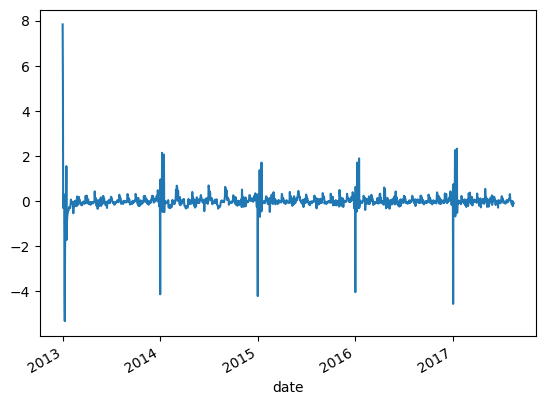

In [17]:
result.resid.plot()
plt.show()

In [10]:
result.resid.mean(), result.resid.std()

(np.float64(-0.016476496750617554), 0.4167219939723814)

### Seasonal Order: (P, D, Q, s)
s = 12 - Seasonal Period, The length of the seasonal cycle

- s = 7 for daily data (weekly seasonality)
- s = 12 for monthly data (yearly seasonality)
- s = 4 for quarterly data
- s = 24 for hourly data (daily seasonality)
- s = 365 for daily data (yearly seasonality)

<br>

P = 2 - Seasonal AR Order, How many past seasonal values influence the current value

(s=12), P=2 means the value is influenced by:
- The value from 12 periods ago (same month last year)
- The value from 24 periods ago (same month two years ago)
> Interpretation: "The current January is influenced by the previous two Januaries"

<br>

D = 1 - Seasonal Differencing Order, How many times we apply seasonal differencing to make the series stationary

(s=12), D=1 means we compute:
- January_2023 - January_2022
- February_2023 - February_2022

> Purpose: Removes seasonal trends

<br>

Q = 1 - Seasonal MA Order, How many past seasonal error terms influence the current value

For monthly data (s = 12), Q=1 means the current value is influenced by:
- The error/ shock from 12 periods ago

> Interpretation: "Unexpected events from the same season last year affect current values"

In [310]:
# rolled = daily_stats.rolling(
#     window = 30,
#     center = True,
#     min_periods = 15,
# ).mean()

# df_log = np.log(daily_stats['total_sales'])
# rolling_df_ewm= df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
# df_ewm = df_log - rolling_df_ewm

# df_ewm.plot()
# plt.show()

In [320]:
from sklearn.model_selection import train_test_split

# log_series = df_ewm
# log_series = np.sqrt(daily_stats['total_sales'])
log_series = np.log(daily_stats['total_sales'])
# log_series, l = stats.boxcox(daily_stats['total_sales'])
# log_series = pd.Series(log_series, index = daily_stats.index)

Q1 = log_series.quantile(0.25)
Q3 = log_series.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 3 * IQR
upper_bound = Q3 + 3 * IQR
cleaned = log_series[(log_series >= lower_bound) & (log_series <= upper_bound)]

train_idx, text_idx = train_test_split(cleaned.index, test_size=0.2, shuffle=False)
train, test = cleaned.loc[train_idx], cleaned.loc[text_idx]

size = len(train)
end = len(cleaned)

model = SARIMAX(
    train,
    order = (1, 1, 1),
    seasonal_order =(1, 1, 1, 30)
)

result = model.fit()
print(result.summary())

                                     SARIMAX Results                                      
Dep. Variable:                        total_sales   No. Observations:                 1343
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 30)   Log Likelihood                 240.844
Date:                            Sat, 11 Oct 2025   AIC                           -471.688
Time:                                    21:10:21   BIC                           -445.791
Sample:                                         0   HQIC                          -461.976
                                           - 1343                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4296      0.075     -5.727      0.000      -0.577      -0.283
ma.L1          0.6727      0.060   

In [ ]:
# Ljung-Box (L1) (Q): 3.62, Prob(Q): 0.06
#   This tests for autocorrelation in the residuals at lag 1.
#   A p-value > 0.05 indicates no significant autocorrelation at this lag.

# Jarque-Bera (JB): 9.53, Prob(JB): 0.01
#   This tests for normality of the residuals.
#   A low p-value (0.01) indicates that the residuals are not normally distributed.

# Heteroskedasticity (H): 0.95, Prob(H) (two-sided): 0.55
#   This tests for constant variance of the residuals.
#   A p-value > 0.05 indicates that the residuals have constant variance. Y

In [322]:
from statsmodels.stats.diagnostic import acorr_ljungbox

residuals = result.resid
res = acorr_ljungbox(residuals, lags=[1], return_df=True)
lb_stat = res['lb_stat'].iloc[0]
lb_pvalue = res['lb_pvalue'].iloc[0] # lb_pvalue > 0.05 is good
lb_pvalue

np.float64(0.14878133568803567)

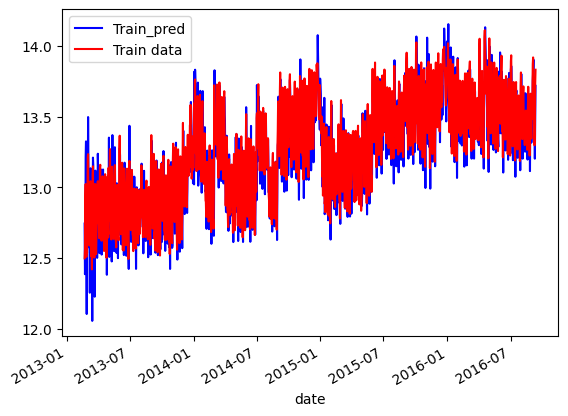

In [278]:
# Remove first 10 items
train_prediction = result.predict(50, size-1)

train_prediction.plot(label = 'Train_pred', color="b")
train[50:].plot(label = 'Train data', color='red')
plt.legend()
plt.show()

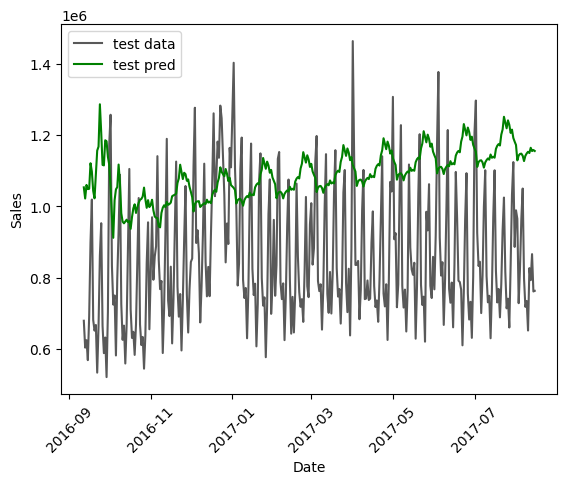

In [321]:
prediction = result.predict(size, end-1).rename('Predicted test')
prediction.index = test.index

# plt.plot(train[50:], label="X_train", color='red')
# plt.plot(train_prediction, label="train_pred", color="b")
plt.plot(np.exp(test), label="test data", color="0.35")
plt.plot(np.exp(prediction), label="test pred", color="green")
plt.ylabel("Sales")
plt.xlabel("Date")
plt.xticks(rotation = 45)
plt.legend()
plt.show()

In [285]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(test, prediction)
rmse = np.sqrt(mean_squared_error(test, prediction))
mape = np.mean(np.abs((test - prediction) / test)) * 100

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

MAE: 0.30, RMSE: 0.35, MAPE: 2.22%


        lb_stat      lb_pvalue
1      5.610590   1.785225e-02
7    690.076449  9.507005e-145
14  1381.820392  1.331968e-286
21  1984.071007   0.000000e+00
30  2608.900910   0.000000e+00


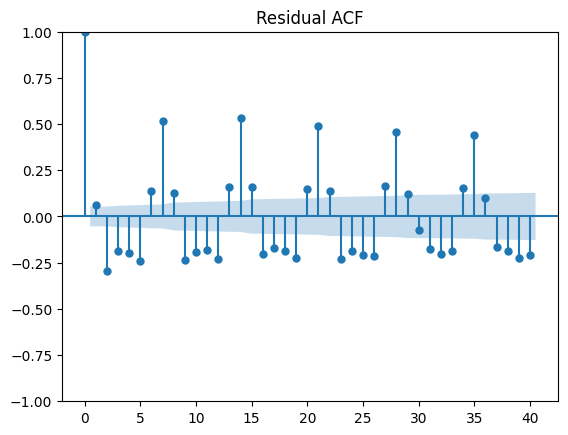

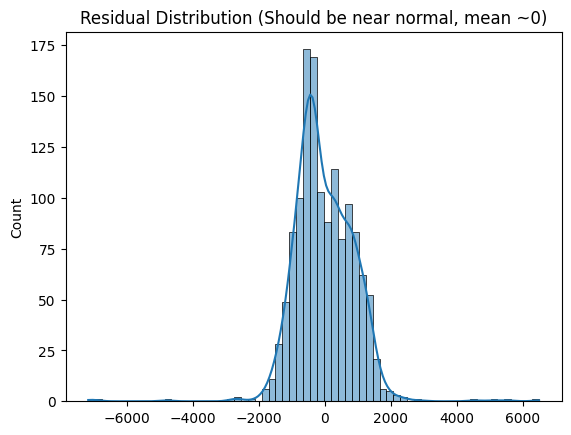

In [236]:
from statsmodels.stats.diagnostic import acorr_ljungbox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns

# Ljung-Box test at multiple lags
lb = acorr_ljungbox(result.resid, lags=[1, 7, 14, 21, 30], return_df=True)
print(lb)

# Visual check
plot_acf(result.resid, lags=40)
plt.title("Residual ACF")
plt.show()

sns.histplot(result.resid, kde=True)
plt.title("Residual Distribution (Should be near normal, mean ~0)")
plt.show()